# Note book to convert Raw data csv from Flux Alpes into NetCDF forcing for CROCUS

!/usr/bin/env python3
 -*- coding: utf-8 -*-

___

Created on Wed April 30, 15:00, 2025
Change to notebook and adapt for Flux Alpes Station 

**Author**: based on Jari-Pekka Nousu's script adapted by Glenn Pitiot

**Resume**\
 SCRIPT TO CREATE FORCING FILE FROM TEXT OR CSV FILE
 FEEL FREE TO BE INSPIRED BY THIS TO CREATE YOUR OWN FORCING FILE
 TXT/CSV --> PD.DATAFRAME --> NCF-FILE

 The FORCING File has mandatory columns. \
 Please note the time column needs to be first and the timezone has to be UTC
 
 [['time', 'CO2air', 'DIR_SWdown', 'HUMREL', 'LWdown', 'NEB', 'PSurf', 'Qair',
 'Rainf', 'SCA_SWdown', 'Snowf', 'Tair', 'Wind', 'Wind_DIR']]

___
**Practical steps**
* I/ Basics Information to full:
* II/ Automatic changes:
     - Options instance inmm
     - Separate solid and liquid precipitation. Under 1°C it's a solid precipitation
* III Final Checking:
* IV Saving netcdf:


# Import

In [1]:
%load_ext autoreload
#%autoreload 2 # reload automaticly libraries
    
import argparse
import datetime

import pandas as pd
# note (S.R., L.V.G.): pandas.read_csv could be replaced by numpy.genfromtxt but pandas is more flexible in the file
# format and is known to be a lot faster and memory efficient for big files.
import netCDF4
import matplotlib.pyplot as plt

import sys
import os

sys.path.append(os.path.abspath("~/private-storage"))

from bronx.meteo.thermo import Thermo
from bronx.meteo.constants import T0
from snowtools.utils.sun import sun

# I/Basics Information to full
## General values, metadata

**Define :** 
* All column names which differ from CROCUS netcdf
* Information for change of units: like inmm

In [2]:

# Nom du fichier d'entrée csv
infile_name = "~/private-storage/CROCUS/data_cdl/Raw_data/2024-2025_Lautaret_halfhour.csv"

# Nom du fichier de sortie netcdf
outfile_name = 'data/FORCING_cdl_2024_2025.nc'

#############################################################
# Station
#########
# Long Lat 
longitude = 6.404625934494025
latitude = 45.04120852665456

# height of wind speed :
height_windspeed = 5.18

# height of temperature measurements :
height_temp =  3.53

# Slope définition  :
slope_orient = 0 # Orientation to the North
slope_angle = 0 # To the horizontale 0 no slope 

# Station définition :
station_height = 2100

# Time  [s]
time_step = 1800

#############################################################
# OPTIONS
#########
# Température in°C ou en K
indC = True #True en degree # False in [K]

# Pression en hPa ou pas ? 
inhP = True # True hPa else False

# Precipitation:
inmm = True

inUTC = True

default_meta_data = ['title=FORCING OF Col de Port from Flux Alpes stations',
                     'summary=This file is meterologial data FORCING from Flux Alpes station Observation Site',
                     'id=FORCING ID', 'contributor_name=Didier Voisin, People 2, People 3',
                     'contributor_role=People 1 collected the observation; People 2 made some modelisation; '
                     'People 3 made some coffee  (huge contribution)']

## Column name in the raw data for identification and rename

In [3]:
# Name of column of Raw data.

CL_Tair = "AirTC_Avg" # temperature 
CL_Psurf = "Patm_Avg" # pressure

CL_RelativeHum = "HRair_Avg"
CL_CO2air = "CO2_Avg" # Concentration C02 kg/m3

# Norm campbell reverse compare to meterological norm about radiative stuf
CL_DIR_SWdown = 'short_up_Avg' # CNR4 : Incident radiation short wavelengths (upward looking sensor) W/m2
CL_LWdown = "long_up_cor_Avg" # CNR4 : Incident radiation long wavelengths (upward looking sensor) W/m2

# No mesurment of nebulosity, let "" if no columns
CL_NEB = ""

CL_Wind = "WindSpeed_Avg"
CL_Wind_DIR = "WindDir"

# Precipitation name columns
CL_Quantity_raw = "Quantity_raw"

# II/ Automatic change
## Add to the parser

In [4]:
parser = argparse.ArgumentParser(
    description="""Create forcing file from txt or csv file.

    TXT/CSV --> PD.DATAFRAME --> NCF-FILE

    The FORCING File has mandatory columns.

    Please note time column needs to be first and timezone has to be UTC.

    [['time', 'CO2air', 'DIR_SWdown', 'HUMREL', 'LWdown', 'NEB', 'PSurf', 'Qair', 'Rainf', 'SCA_SWdown',
    'Snowf','Tair', 'Wind', 'Wind_DIR']]"""
)

parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")

parser.add_argument("-i", "--infile", help="Input csv file", default=infile_name, dest='infile')
parser.add_argument("-o", "--output", help="Output netcdf file",default=outfile_name, dest='outfile')
parser.add_argument("--lon", help="station longitude", dest="LON", default=longitude)
parser.add_argument("--lat", help="station latitude", dest='LAT', default=latitude)
parser.add_argument("--uref", help="height of wind measurements", default=height_windspeed, dest='UREF')
parser.add_argument("--zref", help="height of temperature measurements", default=height_temp, dest='ZREF')
parser.add_argument("--aspect", help="slope orientation", dest='aspect', default=slope_orient)
parser.add_argument("--slope", help="slope angle", default=slope_angle, dest='slope')
parser.add_argument("--zs", help="station height", default=station_height, dest='ZS')


parser.add_argument("--radpart", help="logical: radiation partitioning global to direct and diffuse", default=False, dest='RADPART')
parser.add_argument("--radpart_params", help="reference parameters for radiation partitioning", default='sod', dest='RADPART_PARAMS')
parser.add_argument("--meta", help="add global attributes in form attname=attribute_text. Can be evoced multiple times",
                    dest='metadata', action='append')


parser.add_argument("--timestep", help="Time step in seconds", default=time_step, dest='FRC_TIME_STP')
parser.add_argument("--inUTC", help="UNIT of time stp local or UTC", default=inUTC, dest='inUTC')
parser.add_argument("--in-degreeC", help="Tair provided in °C", action= argparse.BooleanOptionalAction, default=indC, dest='indC')
parser.add_argument("--in-hPa", help="Psurf provided in hPa", action= argparse.BooleanOptionalAction, default=inhP, dest='inhPa')
parser.add_argument("--in-mm", help="Precipitations provided in mm/h ", action= argparse.BooleanOptionalAction, default=inmm, dest='inmm')
args = parser.parse_args()

## Méta data

In [5]:
###########################
# build station information dict
###########################
station_data = {'LAT': float(args.LAT), 'LON': float(args.LON), 'UREF': float(args.UREF), 'ZREF': float(args.ZREF), 'ZS': float(args.ZS),
                'aspect': float(args.aspect), 'slope': float(args.slope), 'FRC_TIME_STP': float(args.FRC_TIME_STP)}

print('Station data assigned as:', station_data)

###################
# treat meta data
##################
if not args.metadata:
    meta_data = default_meta_data
else:
    meta_data = args.metadata
meta_dict = {}
for meta_item in meta_data:
    key, val = meta_item.split("=", 2)
    meta_dict[key] = val


Station data assigned as: {'LAT': 45.04120852665456, 'LON': 6.404625934494025, 'UREF': 5.18, 'ZREF': 3.53, 'ZS': 2100.0, 'aspect': 0.0, 'slope': 0.0, 'FRC_TIME_STP': 1800.0}


## CSV Rename

In [6]:
###########################################################################################
# Processing raw meteo file into pd dataframe
###########################################################################################
# reading the file
meteo_data = pd.read_csv(args.infile, sep=",", index_col=0,)
meta_data = pd.read_csv("~/private-storage/CROCUS/data_cdl/Raw_data/metadata.csv", sep=",")

In [7]:
meteo_data.head()

,short_up_Avg,Albedo_Avg,long_up_cor_Avg,Quantity_raw,AirTC_Avg,WindSpeed_Avg,Patm_Avg,HRair_Avg,Snow_Depth,WindDir,...,len_gap_short_up_Avg,len_gap_Albedo_Avg,len_gap_long_up_cor_Avg,len_gap_Quantity_raw,len_gap_AirTC_Avg,len_gap_WindSpeed_Avg,len_gap_Patm_Avg,len_gap_HRair_Avg,len_gap_Snow_Depth,len_gap_WindDir
datetime,,,,,,,,,,,,,,,,,,,,,
2024-10-17 00:00:00+00:00,-0.616610,NaN,331.2893,0.0,6.761500,4.889,797.7,99.998,NaN,69.39,...,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
2024-10-17 00:30:00+00:00,-0.233310,NaN,339.9427,0.0,6.761500,3.381,797.9,99.998,NaN,19.02,...,0.0,16.0,0.0,6.0,0.0,0.0,0.0,0.0,1216.0,0.0
2024-10-17 01:00:00+00:00,-0.833252,NaN,341.3750,0.0,6.613400,2.360,797.9,99.998,NaN,353.50,...,0.0,16.0,0.0,6.0,0.0,0.0,0.0,0.0,1216.0,0.0
2024-10-17 01:30:00+00:00,-0.533284,NaN,344.8227,0.0,6.502399,2.556,797.8,99.998,NaN,50.54,...,0.0,16.0,0.0,6.0,0.0,0.0,0.0,0.0,1216.0,0.0
2024-10-17 02:00:00+00:00,-0.316640,NaN,344.5900,0.0,6.369900,3.750,797.4,99.998,NaN,73.75,...,0.0,16.0,0.0,6.0,0.0,0.0,0.0,0.0,1216.0,0.0


La partition entre, les précipitiations liquides et solides ne sont pas faite donc : 

## Rename column names of raw data and separate solid and liquid precipitation:

<span style="color:red">
/!\ Change of Quantity_raw name of precipitation column required for spliting 
</span>

In [8]:
# Nebulosité
if CL_NEB =="": 
    meteo_data["NEB"] = 0 # Between 0 and 1, 0 corespond to clear sky
else:
    meteo_data.rename(columns={CL_NEB: "NEB"})
                      
# Change colum name
meteo_data = meteo_data.rename(columns={CL_Tair: 'Tair',
                                        CL_Psurf: 'PSurf',
                                        CL_RelativeHum:"HUMREL",
                                        CL_CO2air: "CO2air",
                                        CL_DIR_SWdown: "DIR_SWdown",
                                        CL_LWdown: "LWdown",
                                        CL_NEB : "NEB",
                                        CL_Wind: "Wind",
                                        CL_Wind_DIR: "Wind_DIR"
                                       })

# Separate snow and rain, with temperature as marquer
masque = meteo_data.Tair < 1

# Seperate solid and liquid precipitation
meteo_data["Rainf"] = meteo_data[~masque][CL_Quantity_raw]
meteo_data["Snowf"] = meteo_data[masque][CL_Quantity_raw]
meteo_data = meteo_data.fillna(0)

meteo_data.index = pd.to_datetime(meteo_data.index)

## Apply changes with options

In [9]:
# Changement de °C à Kelvin:
if args.indC: meteo_data['Tair'] = meteo_data['Tair'] + T0

# Changement en Pa si hPa
if args.inhPa: meteo_data['PSurf'] = meteo_data['PSurf'] * 100.

# Passage de mm en kg/m²/s donc [mm]*10e3*rho_e/Time_step = [kg/m²/s]
if args.inmm:
    meteo_data['Rainf'] = meteo_data['Rainf'] / args.FRC_TIME_STP
    meteo_data['Snowf'] = meteo_data['Snowf'] / args.FRC_TIME_STP
    
# assigning fill value
fill_value = -9999999

# calculating Qair (specific humidity) from Pressure, relative humidity and Temperature
meteo_data["Qair"] = Thermo(['v', 'c'], dict(P=meteo_data["PSurf"], Huw=meteo_data["HUMREL"],
                                             T=meteo_data["Tair"], rc=0)).get('qv')


# SCA SWdown fix to 0 because no need to differentiate this file.
if 'SCA_SWdown' not in meteo_data.columns:
    meteo_data['SCA_SWdown'] = 0.

# Partition direct dif
if bool(args.RADPART) == True:
    print('Radiation partitioning set as True, using sun().directdiffus method')
    meteo_data['DIR_SWdown'], meteo_data['SCA_SWdown'] = sun().directdiffus(meteo_data['DIR_SWdown'],
                                                                            meteo_data.index, station_data['LAT'],
                                                                            station_data['LON'], station_data['slope'],
                                                                            station_data['aspect'], site=args.RADPART_PARAMS)

# assign CO2 (should not matter for snow simulations?)
if 'CO2air' not in meteo_data.columns:
    meteo_data['CO2air'] = 0.00062
    print('CO2air not assigned, filling with constant 0.00062')

# saving only the necessary variables in a new df
meteo_data = meteo_data[['CO2air', 'DIR_SWdown', 'HUMREL',
                        'LWdown', 'NEB', 'PSurf', 'Qair', 'Rainf',
                        'SCA_SWdown', 'Snowf', 'Tair', 'Wind', 'Wind_DIR']]

# in case nan, fill with fill_value=-9999999
# some variables do not need to be perfect, some do

meteo_data = meteo_data.fillna(fill_value)
print("#Data frame final")
meteo_data.head()

CO2air not assigned, filling with constant 0.00062
#Data frame final


,CO2air,DIR_SWdown,HUMREL,LWdown,NEB,PSurf,Qair,Rainf,SCA_SWdown,Snowf,Tair,Wind,Wind_DIR
datetime,,,,,,,,,,,,,
2024-10-17 00:00:00+00:00,0.00062,-0.616610,99.998,331.2893,0,79770.0,0.007719,0.0,0.0,0.0,279.921500,4.889,69.39
2024-10-17 00:30:00+00:00,0.00062,-0.233310,99.998,339.9427,0,79790.0,0.007717,0.0,0.0,0.0,279.921500,3.381,19.02
2024-10-17 01:00:00+00:00,0.00062,-0.833252,99.998,341.3750,0,79790.0,0.007638,0.0,0.0,0.0,279.773400,2.360,353.50
2024-10-17 01:30:00+00:00,0.00062,-0.533284,99.998,344.8227,0,79780.0,0.007581,0.0,0.0,0.0,279.662399,2.556,50.54
2024-10-17 02:00:00+00:00,0.00062,-0.316640,99.998,344.5900,0,79740.0,0.007515,0.0,0.0,0.0,279.529900,3.750,73.75


# III/ Check for data frame.

This part is required before saving, netcdf, an overlook of all the data is important.


* <span style="color:red"> Check unit and coherence of number </span>

* <span style="color:red">Check of lack of data </span>

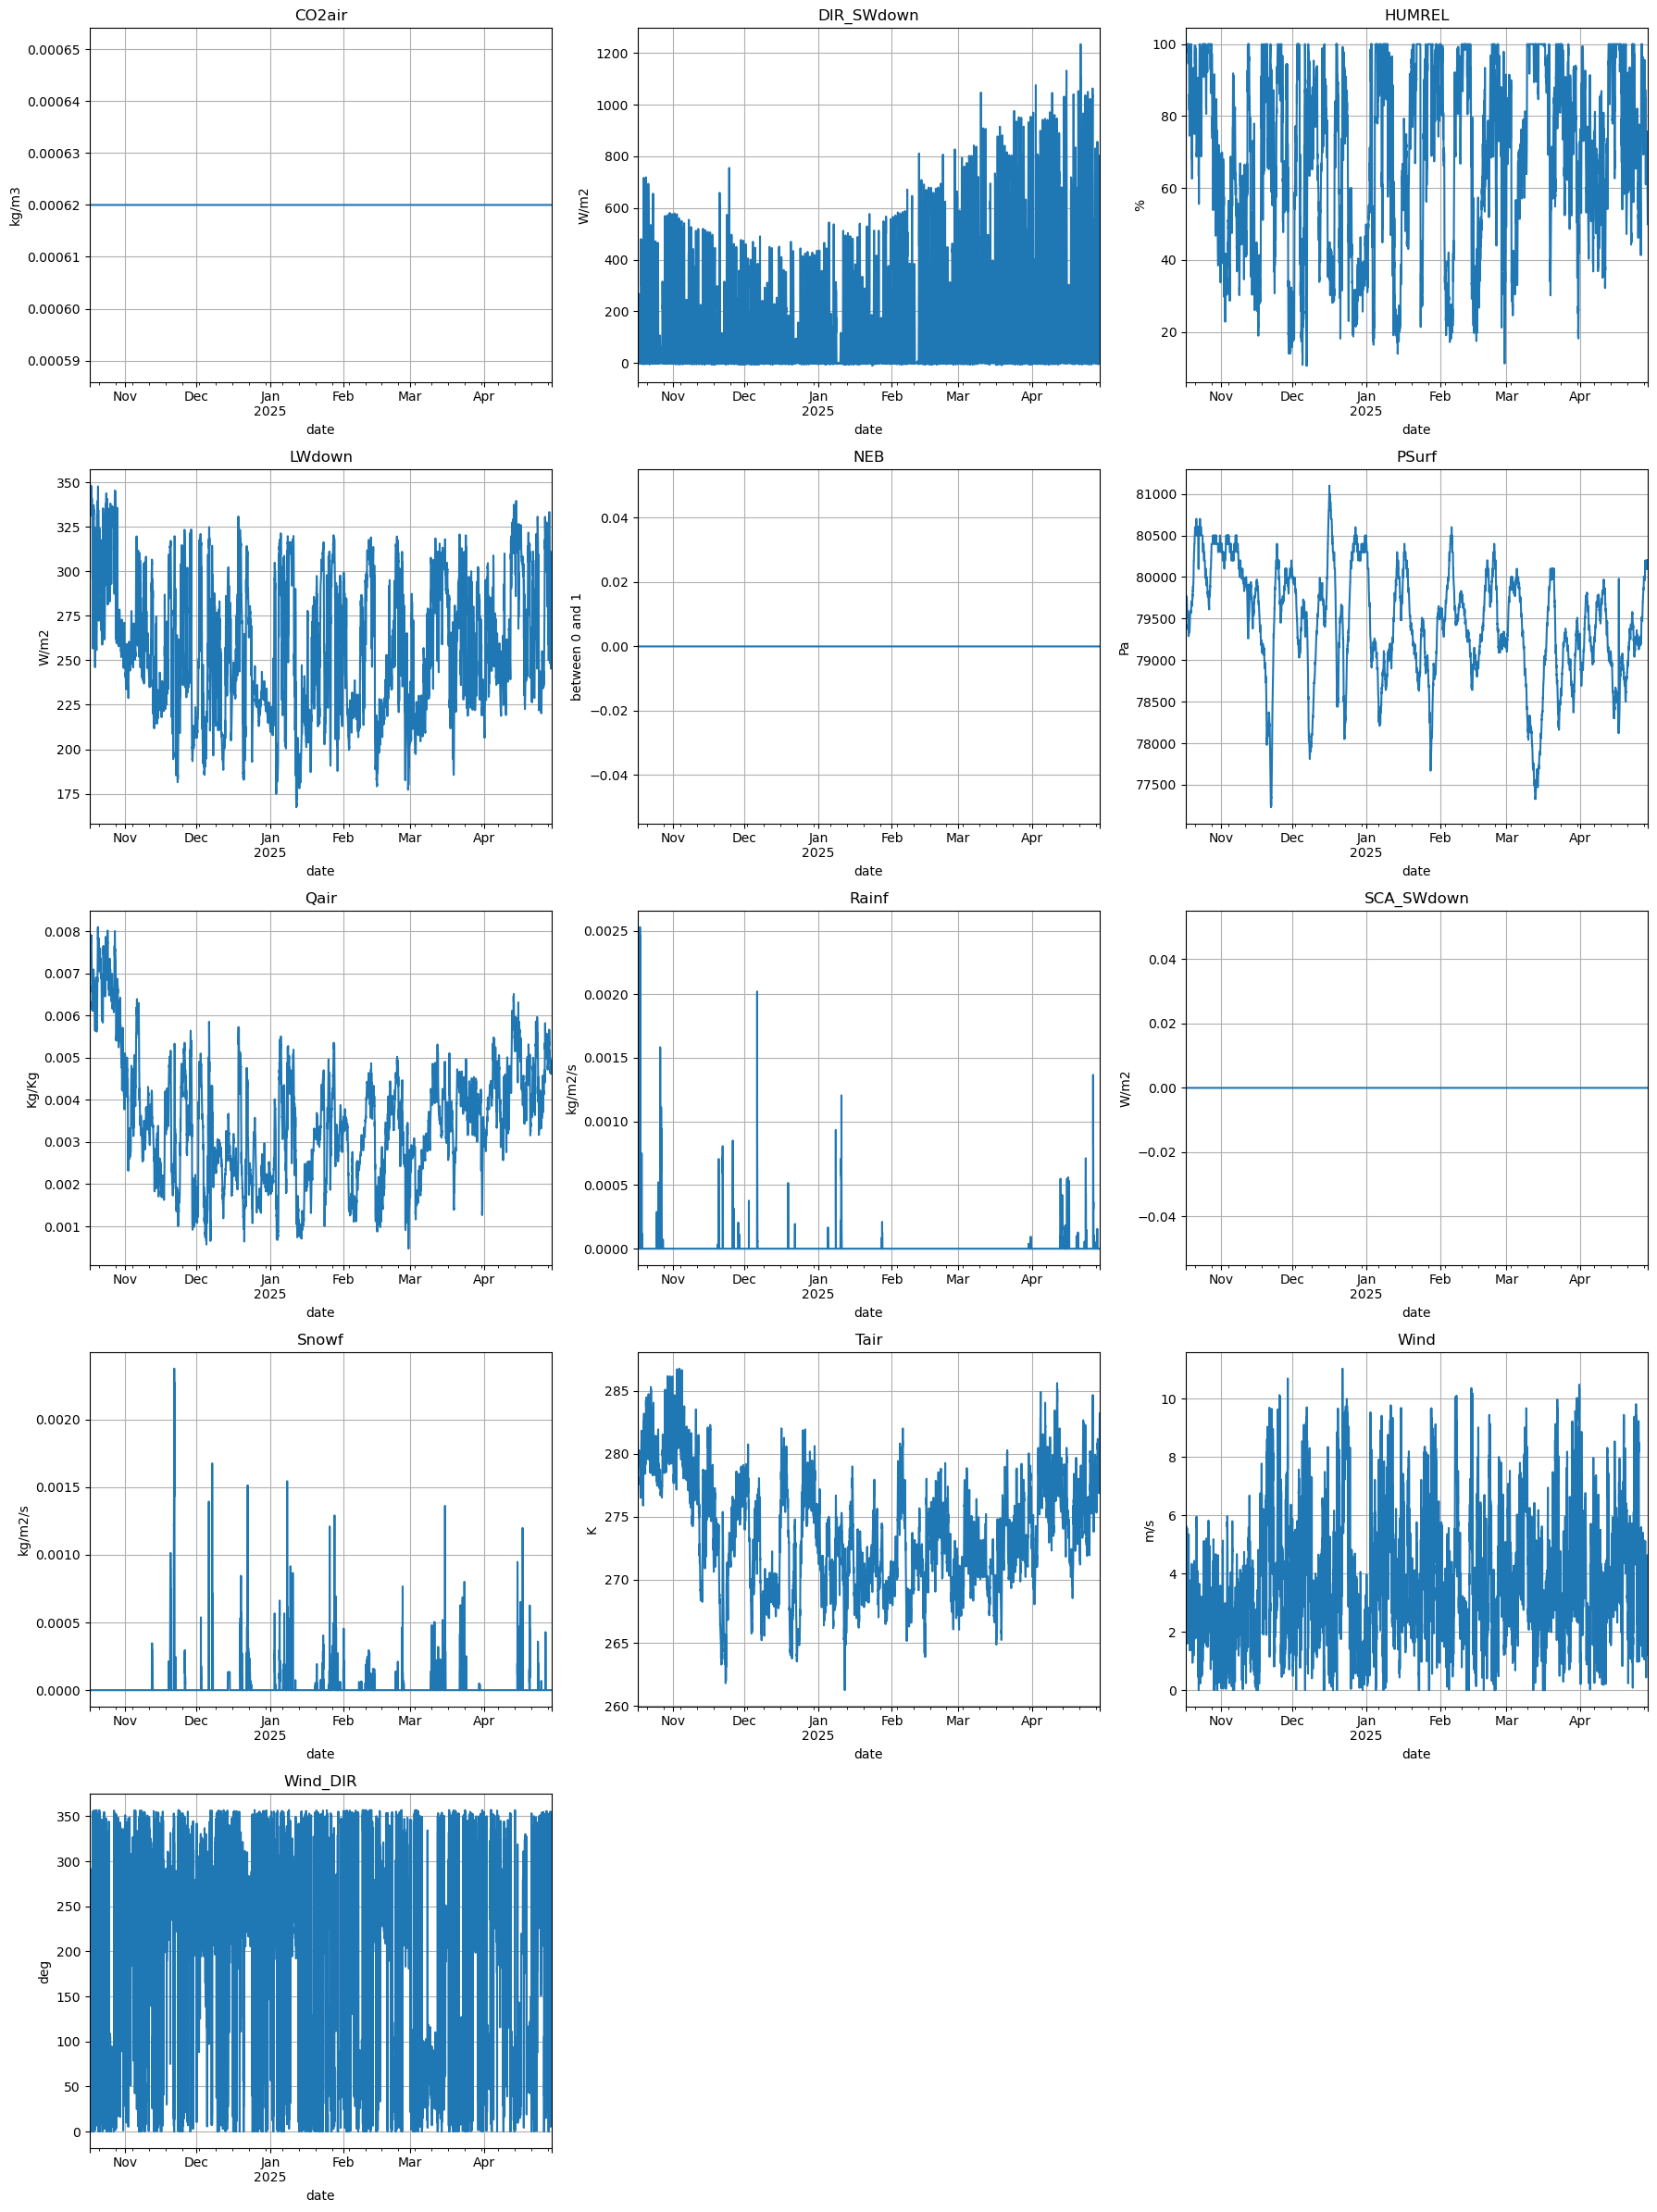

In [21]:
Units = ["",'kg/m3', 'W/m2', '%', 'W/m2', 'between 0 and 1', 'Pa', 'Kg/Kg', 'kg/m2/s',
                               'W/m2', 'kg/m2/s', 'K', 'm/s', 'deg']

fig = plt.figure(figsize=(18, 24))
i=0
for column in Columns:
    i=i+1
    fig.add_subplot(5,3,i)
    meteo_data[column].plot()
    plt.title(str(column))
    plt.ylabel(Units[i])
    plt.xlabel('date')
    plt.grid()
plt.tight_layout()
plt.show()

# IV/ Netcdf creation

In [22]:
###########################################################################################
# NETCDF FILE CREATION
###########################################################################################


# first date
first_date = meteo_data.index[0]

# list of dates in right format
List_dates = meteo_data.index

# creating the netcdf file: dataset
with netCDF4.Dataset(args.outfile, 'w', format='NETCDF4_CLASSIC') as fic_forcing:

    # creating the netcdf file: dimensions
    fic_forcing.createDimension('time', None)
    fic_forcing.createDimension('Number_of_points', 1)

    # defining time dimension
    unit_time = 'seconds since ' + str(first_date)
    time = netCDF4.date2num(List_dates, unit_time,has_year_zero= False)

    time_nc = fic_forcing.createVariable('time', 'f', ('time',), fill_value=fill_value)
    time_nc.units = unit_time
    time_nc[:] = time

    # creation and definition of Time Step
    frc_nc = fic_forcing.createVariable('FRC_TIME_STP', 'f', fill_value=fill_value)
    frc_nc.units = 's'
    frc_nc[:] = station_data["FRC_TIME_STP"]

    # variables with 2 dimensions and their metadata
    List_nom_time_nbpoint = ['CO2air', 'DIR_SWdown', 'HUMREL', 'LWdown', 'NEB', 'PSurf', 'Qair', 'Rainf',
                             'SCA_SWdown', 'Snowf', 'Tair', 'Wind', 'Wind_DIR']

    List_unite_time_nbpoint = ['kg/m3', 'W/m2', '%', 'W/m2', 'between 0 and 1', 'Pa', 'Kg/Kg', 'kg/m2/s',
                               'W/m2', 'kg/m2/s', 'K', 'm/s', 'deg']

    List_longname_time_nbpoint = ['Near Surface CO2 Concentration', 'Surface Incident Direct Shortwave Radiation',
                                  'Relative Humidity', 'Surface Incident Longwave Radiation', 'Nebulosity',
                                  'Surface Pressure', 'Near Surface Specific Humidity',
                                  'Rainfall Rate', 'Surface Incident Diffuse Shortwave Radiation', 'Snowfall Rate',
                                  'Near Surface Air Temperature',
                                  'Wind Speed', 'Wind Direction']

    # variables with 1 dimension and their metadata
    List_nom_nbpoint = ['LAT', 'LON', 'UREF', 'ZREF', 'ZS', 'aspect', 'slope']

    List_unite_nbpoint = ['degrees_north', 'degrees_east', 'm', 'm', 'm', 'degrees from north',
                          'degrees from horizontal']

    List_longname_nbpoint = ['latitude', 'longitude', 'Reference_Height_for_Wind', 'Reference_Height', 'altitude',
                             'slope aspect', 'slope angle']

    # Creating 2 dimensions variables
    for i in range(len(List_nom_time_nbpoint)):
        fic_nc = fic_forcing.createVariable(List_nom_time_nbpoint[i], 'f', ('time', 'Number_of_points'),
                                            fill_value=fill_value)
        fic_nc.units = List_unite_time_nbpoint[i]
        fic_nc.long_name = List_longname_time_nbpoint[i]

    # Creating 1 dimension variables
    for i in range(len(List_nom_nbpoint)):
        fic_nc = fic_forcing.createVariable(List_nom_nbpoint[i], 'f', ('Number_of_points',), fill_value=fill_value)
        fic_nc.units = List_unite_nbpoint[i]
        fic_nc.long_name = List_longname_nbpoint[i]

    # Filling the variables with pd dataframe (2 dimensions)
    for i in range(len(List_nom_time_nbpoint)):
        vari = List_nom_time_nbpoint[i]
        try:
            fic_forcing[vari][:] = meteo_data[vari].values
        except IndexError:
            print("there is no", List_nom_time_nbpoint[i], "data available")

    # Filling the variables with pd dataframe (1 dimension)
    for i in range(len(List_nom_nbpoint)):
        vari = List_nom_nbpoint[i]
        try:
            fic_forcing[vari][0] = station_data[vari]
        except KeyError:
            print("there is no", List_nom_nbpoint[i], "data available")

    # Others Metadata
    for key, description in meta_dict.items():
        fic_forcing.setncattr(key, description)

    fic_forcing.date_created = datetime.datetime.today().replace(second=0, microsecond=0).isoformat()